## Using SHAP for interpretability

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb
from ngboost import NGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score

import pickle
import shap
shap.initjs()

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
group_one = dataset[dataset["Diagnosis"] == 0]
group_two = dataset[dataset["Diagnosis"] == 2]

combined_group_one = pd.concat([group_one, group_two], ignore_index = True)
combined_group_one["Diagnosis"].unique()

array([0, 2])

In [4]:
combined_group_one

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
1,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
2,14,1,78.6137,0,29.0,0.12,188.33,0.49,183.76,39.63,...,241.64,0.44,226.48,35.11,664.29,3.10,8478.33,3.01,1809.0,3292.0
3,15,0,80.9068,0,29.0,0.10,161.28,0.54,174.53,35.94,...,221.76,0.45,NaN,30.57,NaN,3.12,4287.78,2.90,2188.0,3603.0
4,16,0,65.5205,0,28.0,0.12,166.97,0.58,202.96,38.42,...,228.53,0.50,228.72,28.98,686.36,2.90,-1381.99,2.73,1829.0,3695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,549,0,68.8849,2,25.0,0.11,169.76,0.58,205.91,38.90,...,219.32,0.53,229.07,30.38,696.95,3.05,1.54,3.53,2140.0,3801.0
274,658,0,72.2822,2,30.0,0.13,187.66,0.57,222.54,37.58,...,206.16,0.55,227.90,30.10,705.46,3.03,281.47,NaN,2750.0,3345.0
275,1244,0,79.0877,2,24.0,0.13,152.52,0.63,208.54,35.72,...,220.67,0.53,231.71,30.18,706.18,3.02,28.95,2.98,2016.0,3532.0
276,1311,0,69.2110,2,29.0,0.10,175.27,0.50,187.40,44.04,...,222.69,0.52,229.54,32.03,695.47,3.05,2811.38,2.98,1605.0,3219.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_group_one.drop("Diagnosis", axis=1),  
    combined_group_one["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((194, 23), (84, 23))

In [6]:
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [8]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [9]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((194, 23), (84, 23))

In [10]:
model = GradientBoostingClassifier(random_state=42,)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(random_state=42),
                            scoring='roc_auc_ovr', threshold=0.0005)

In [11]:
# select features
X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_train_t.shape, X_test_t.shape

((194, 15), (84, 15))

In [12]:
with open("rf_model_group_one.pkl", "rb") as file:
    loaded_model_rf = pickle.load(file)
print(f"{loaded_model_rf} model loaded successfully!\n")

with open("xgboost_model_group_one.pkl", "rb") as file:
    loaded_model_xgb = pickle.load(file)
print(f"{loaded_model_xgb} model loaded successfully!\n")


with open("ngboost_model_group_one.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)
print(f"{loaded_model_ngb} model loaded successfully!")

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, min_samples_leaf=0.0018722767184508292,
                       min_samples_split=0.03401797068956619, n_estimators=175,
                       random_state=42) model loaded successfully!

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6446312268801762, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.9336593623899134,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18400803470491986,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              mul

In [13]:
# Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(loaded_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_t)

# Compute SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(loaded_model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

# Compute SHAP values for NGBoost
explainer_ngb = shap.Explainer(loaded_model_ngb.predict_proba, X_test_t)
shap_values_ngb = explainer_ngb(X_test_t)

PermutationExplainer explainer: 85it [03:22,  2.41s/it]                        


In [14]:
print(shap_values_rf.shape)
print(shap_values_xgb.shape)
print(shap_values_ngb.shape)

(84, 15, 2)
(84, 15)
(84, 15, 2)


## Local interpretability

In [15]:
## SHAP plot for loc trees
explainer_rf = shap.TreeExplainer(loaded_model_rf) 
shap_values_rf = explainer_rf.shap_values(X_test_t)

print(shap_values_rf.shape)
print(explainer_rf.expected_value)

(84, 15, 2)
[0.5 0.5]


In [16]:
# Force plot for the first instance
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0, :, 1], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

In [17]:
# Force plot for the first instance (class 1)
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[0, :, 0], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

### Plot SHAP beeswarm plots for each class (local per-class perspective)

- For models like Random Forest and NGBoost, which produce class-specific SHAP values (3D arrays), we extract SHAP values per class.
- For XGBoost, which outputs a single set of SHAP values (2D array) for binary classification, the same plot is used for each class iteration (as it doesn’t produce per-class values).
- This approach helps visualize feature importance and distribution of SHAP values for each individual class outcome.

SHAP Beeswarm Plot for Class 0


C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2087211388.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


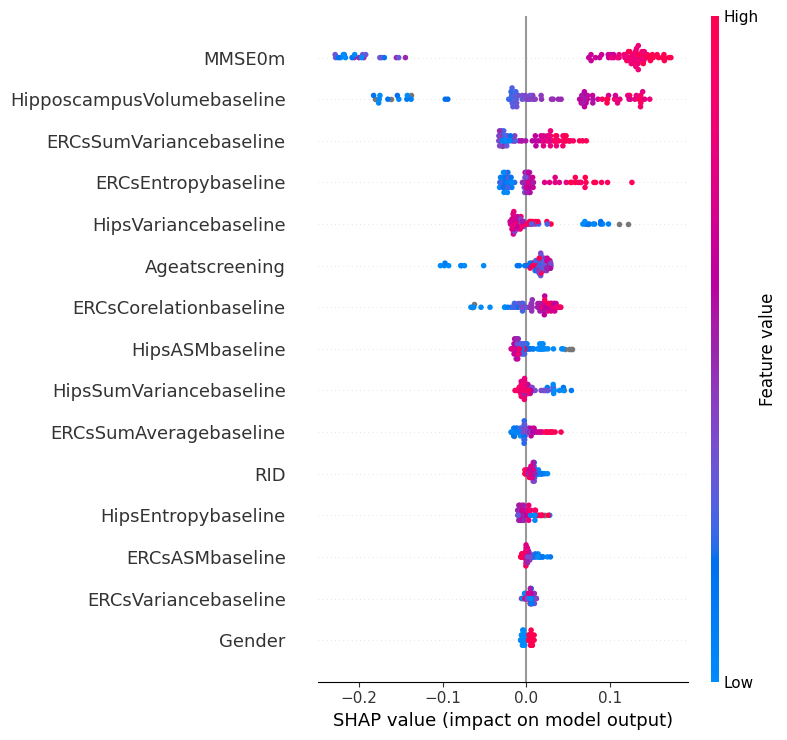

C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2087211388.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns)


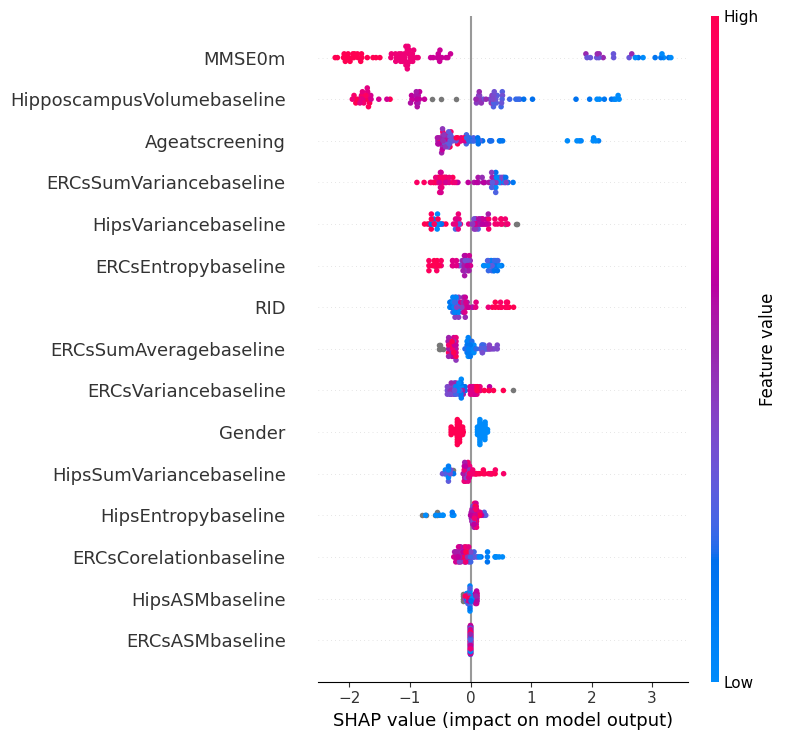

C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2087211388.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


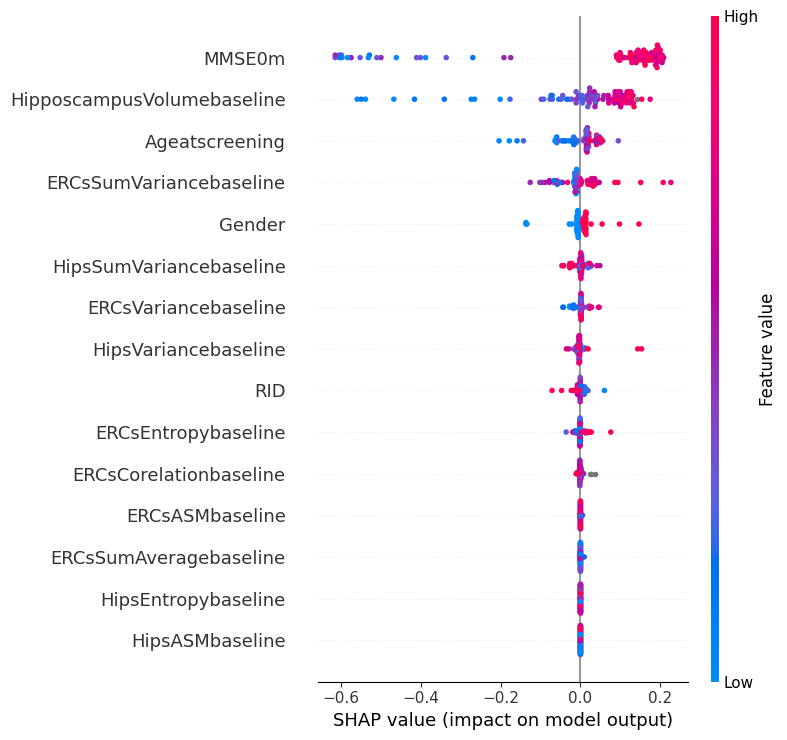

SHAP Beeswarm Plot for Class 1


C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2087211388.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


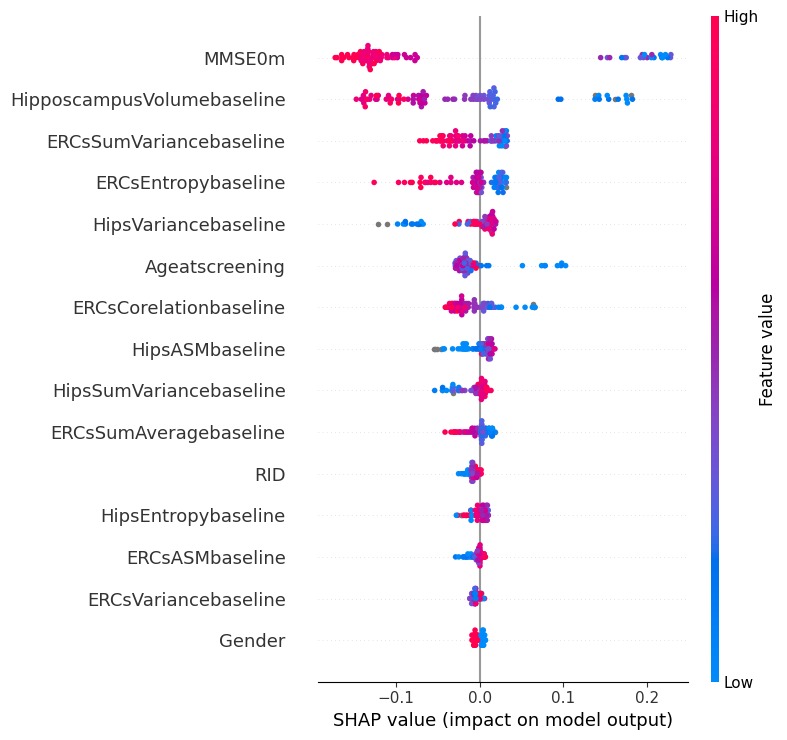

C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2087211388.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns)


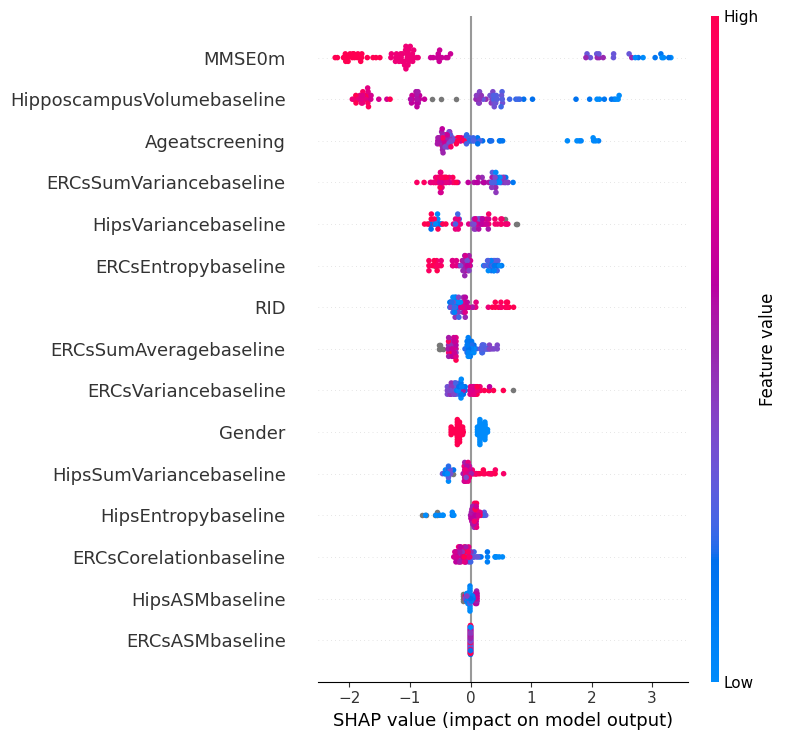

C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2087211388.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


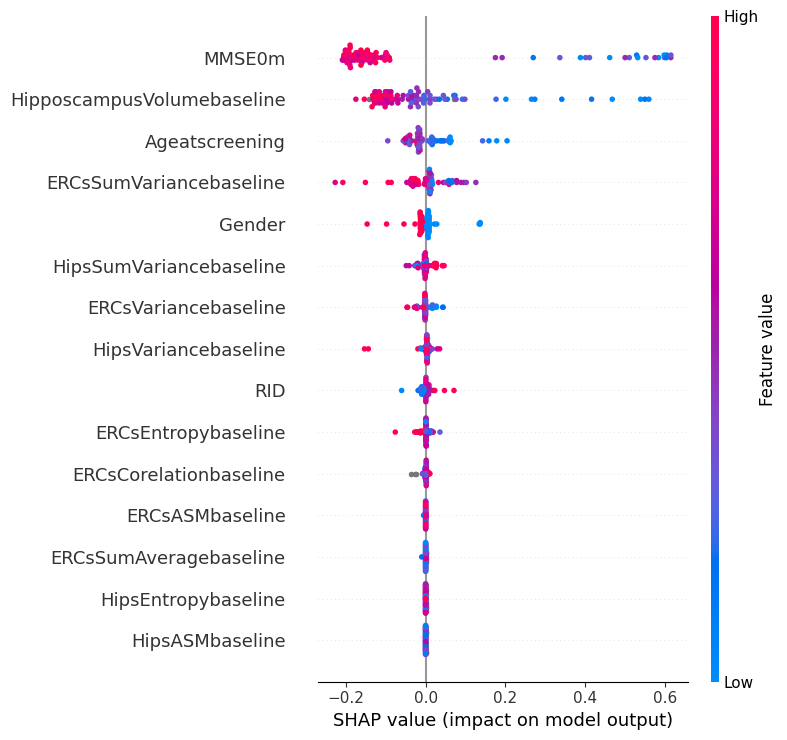

In [18]:
# Plot SHAP beeswarm for each class
for class_idx in range(shap_values_rf.shape[2]):  # Loop over each class (0 and 1)
    print(f"SHAP Beeswarm Plot for Class {class_idx}")

    # For Random Forest
    shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # For XGBoost (shap_values_xgb is 2D, so no need for class_idx)
    shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns)

    # For NGBoost (assuming shap_values_ngb has the same structure as RF, i.e., 3D)
    shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


# Plot aggregated (global) SHAP beeswarm plots across all classes

- XGBoost produces a single 2D array of SHAP values for binary classification, so no aggregation is needed.
- This approach provides a single global view of overall feature importance, irrespective of class, offering a concise summary of how each feature contributes to model predictions across the dataset.


## Global interpretability

C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2244625953.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)


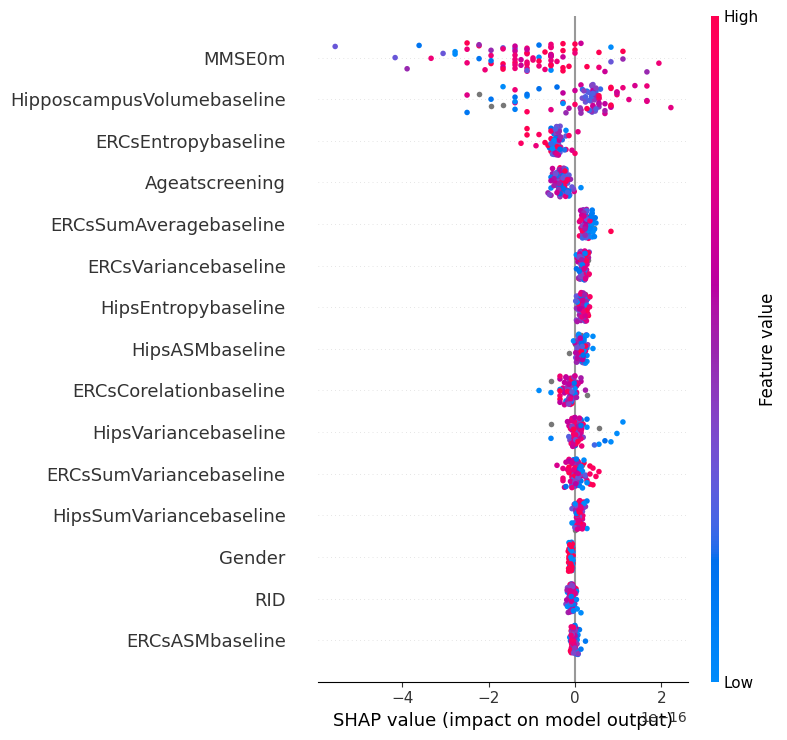

C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2244625953.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)


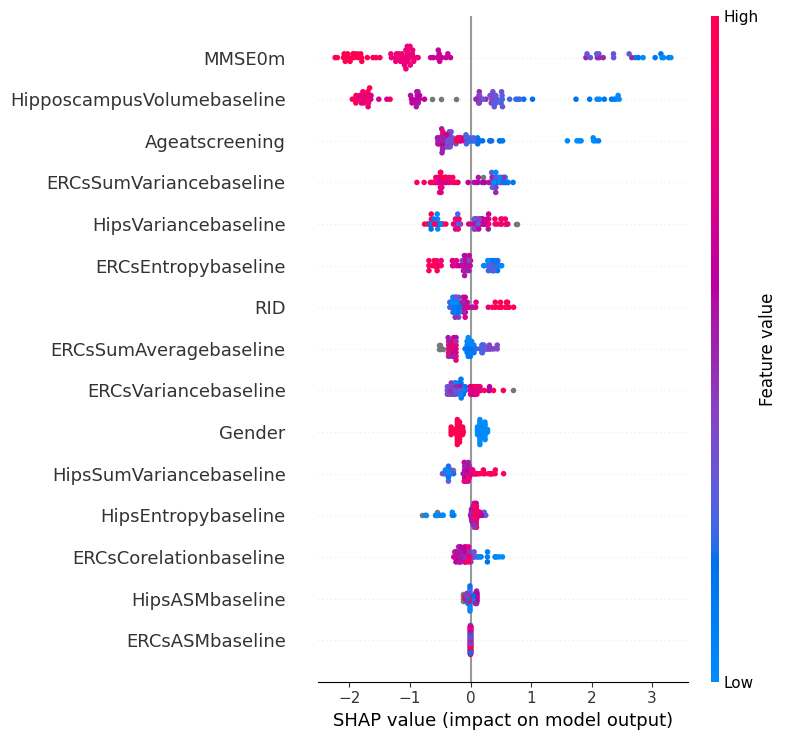

C:\Users\steve\AppData\Local\Temp\ipykernel_11144\2244625953.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)


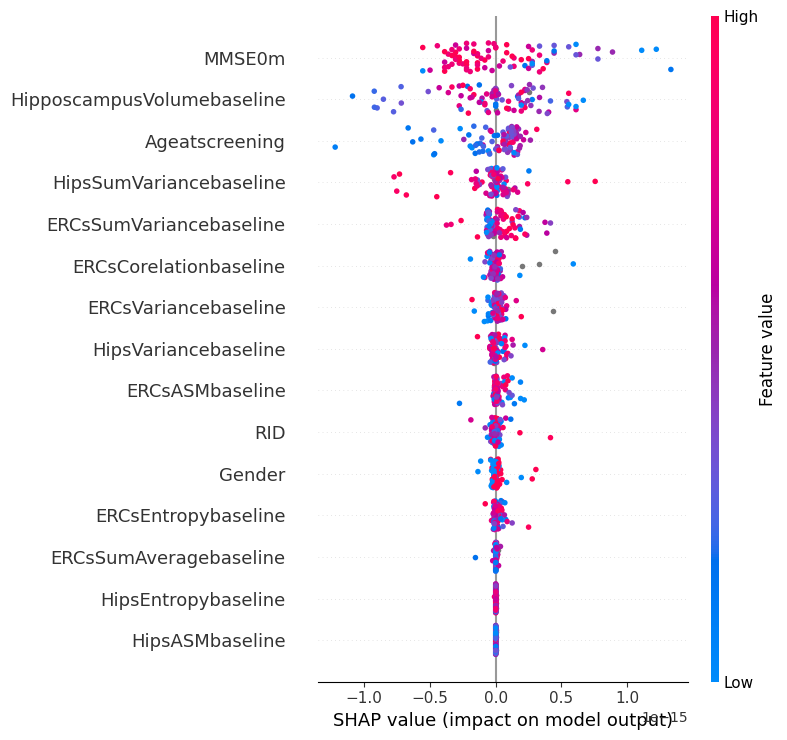

In [19]:
# Sum over classes for models with 3D SHAP arrays
shap_values_rf_sum = shap_values_rf.sum(axis=2)
shap_values_ngb_sum = shap_values_ngb.values.sum(axis=2)

# XGBoost SHAP values are already 2D — no need to sum
shap_values_xgb_sum = shap_values_xgb  # keep as-is

# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)